In [ ]:
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud

import pandas as pd
import random, time
from babel.dates import format_date, format_datetime, format_time
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, accuracy_score


import torch
from torch import Tensor
from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import torch.nn.functional as F
!pip install transformers
import transformers, os
from transformers import BertModel, AutoModel, AdamW, get_linear_schedule_with_warmup, BertTokenizer, BertForSequenceClassification

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 80.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 28.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 111.0 MB/s eta 0:00:00


In [ ]:
# Check device
# Get the GPU device name if available.
if torch.cuda.is_available():
    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")
    print('There are %d GPU(s) available. {}'.format(torch.cuda.device_count()))
    print('We will use the GPU: {}'.format(torch.cuda.get_device_name(0)))

# If we dont have GPU but a CPU, training will take place on CPU instead
else:
    device = torch.device("cpu")

torch.cuda.empty_cache()

# Set the seed value all over the place to make this reproducible.
seed_val = 42

There are %d GPU(s) available. 1
We will use the GPU: NVIDIA A100-SXM4-40GB


In [ ]:
train_file = "train.txt"
label_file = "WN23_PA_training_labels.txt"
test_file = "test.txt"
train_df = pd.read_csv(train_file, sep = ",",encoding = "ISO-8859-1")
label_df = pd.read_csv(label_file, sep = ",", encoding = "ISO-8859-1")
test_df = pd.read_csv(test_file, sep = ",", encoding = "ISO-8859-1")
print(train_df.head())

   TweetID  TimeOfDay                                              Tweet
0     1001         17  The Bulldogs have been selected to finish 4th ...
1     1002         22  Played disc golf. Got a tattoo. Heading to Det...
2     1003         16  Sunday big football game I'm gunna gather all ...
3     1004         20  Despite my resolution to be nicer to Scooter t...
4     1005         18  Reassigned by Michigan Runner to shoot Goodlif...


## Term frequencies

In [ ]:
## Check the word frequency in texts
#
## lemmatize text column by using a lemmatize function
#def lemmatize_text(text):
#    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text.lower())]
#
#
## Initialize the Lemmatizer and Whitespace Tokenizer
#w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
#lemmatizer = nltk.stem.WordNetLemmatizer()
#
## Lemmatize words
#df['text_lemmatized'] = df.text.apply(lemmatize_text)
#df['text_lemmatized'] = df['text_lemmatized'].apply(lambda x: [word for word in x if word not in stop_words])
#
## use explode to expand the lists into separate rows
#wf_text = df.text_lemmatized.explode().to_frame().reset_index(drop=True)
#
## plot
#sns.countplot(x='text_lemmatized', data=wf_text, order=wf_text.text_lemmatized.value_counts().iloc[:10].index)
#plt.xlabel('Most common used words in all texts')
#plt.ylabel('Frequency [%]')
#plt.xticks(rotation=70)

In [ ]:
## Check the word frequency in titles
#
## Lemmatize words
#df['title_lemmatized'] = df.title.apply(lemmatize_text)
#df['title_lemmatized'] = df['title_lemmatized'].apply(lambda x: [word for word in x if word not in stop_words])
#
## use explode to expand the lists into separate rows
#wf_title = df.title_lemmatized.explode().to_frame().reset_index(drop=True)
#
## plot dfe
#sns.countplot(x='title_lemmatized', data=wf_title, order=wf_title.title_lemmatized.value_counts().iloc[:10].index)
#plt.xlabel('Most common used words in all titles')
#plt.ylabel('Frequency [%]')
#plt.xticks(rotation=70)

# Cleaning the data

In [ ]:
def regex_preprocessing(text: str) -> str:
     url = r"(?:http|https):\/\/[a-zA-Z0-9]*\.[a-zA-Z0-9]*\/[a-zA-Z0-9]*\/[a-zA-Z0-9]*|(?:http|https):\/\/t\.co\/[a-zA-Z0-9]*|(?:http|https):\/\/[a-zA-Z0-9]*\.[a-zA-Z0-9]*\/[a-zA-Z0-9]*"
     linebreak = r"\n"
     username = r"@[a-zA-Z0-9_]*(?! )"
     otherchar = r"(?:&amp;|#|_{2,}|\.{2,}|\\n|\\)"
     charnorm = r"([A-Za-z])\1{2,}"
     w = r"w\/" # about
     at = r"@ " # about 204 occurences

     text = re.sub(url, '', text)
     text = re.sub(linebreak, '', text)
     text = re.sub(username, '', text)
     text = re.sub(otherchar, '', text)
     text = re.sub(w, "with ", text)
     text = re.sub(at, "at ", text)
     text = re.sub(charnorm, r"\1", text)

     return text

In [ ]:
train_df['Tweet'] = train_df['Tweet'].apply(lambda x: regex_preprocessing(x)).apply(lambda x: " ".join(x))
test_df['Tweet'] = test_df['Tweet'].apply(lambda x: regex_preprocessing(x)).apply(lambda x: " ".join(x))

train_df = train_df['Tweet']
label_df = label_df['Label']
test_df = test_df['Tweet']

In [ ]:
# #  Preprocess train dataset
# # remove special characters from text column
# text_df.Tweet = text_df.Tweet.str.replace('[#,@,&]', '')
# # Remove digits
# text_df.Tweet = text_df.Tweet.str.replace('\d*','')
# #Remove www
# text_df.Tweet = text_df.Tweet.str.replace('w{3}','')
# # remove urls
# text_df.Tweet = text_df.Tweet.str.replace("http\S+", "")
# # remove multiple spaces with single space
# text_df.Tweet = text_df.Tweet.str.replace('\s+', ' ')
# #remove all single characters
# text_df.Tweet = text_df.Tweet.str.replace(r'\s+[a-zA-Z]\s+', '')

# # Remove english stopwords
# text_df['text'] = text_df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

In [ ]:
# Split test and train data using 25% of the dataset for validation purposes
x_train, x_test, y_train, y_test = train_test_split(train_df, label_df, test_size = 0.2)

In [ ]:
X_train_Transformer, X_val_Transformer, y_train_Transformer, y_val_Transformer = train_test_split(
                                                    x_train, y_train, test_size=0.20, random_state=42)

# Try transformer model

In [ ]:
model_name = 'bert-base-uncased'
SEQ_LEN = 300
batch_size = 16
epochs = 5
learning_rate = 1e-5 # Controls how large a step is taken when updating model weights during training.
steps_per_epoch = 50
num_workers = 3

In [ ]:
def get_split(text1):
    '''Get split of the text with 200 char lenght'''
    l_total = []
    l_parcial = []
    if len(text1.split())//150 >0:
        n = len(text1.split())//150
    else:
        n = 1
    for w in range(n):
        if w == 0:
            l_parcial = text1.split()[:200]
            l_total.append(" ".join(l_parcial))
        else:
            l_parcial = text1.split()[w*150:w*150 + 200]
            l_total.append(" ".join(l_parcial))
    return str(l_total)

# Splits train and validation sets to be feed to the transformer which only accepts 512 tokens maximum
split_train_text = [get_split(t) for t in X_train_Transformer]
split_valid_text = [get_split(t) for t in X_val_Transformer]
split_test_text = [get_split(t) for t in x_test]

In [ ]:
#split_valid_text

In [ ]:
# Load the RoBERTa tokenizer and tokenize the data
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained(model_name, do_lower_case=True)

Loading BERT tokenizer...


In [ ]:
trencoding = tokenizer.batch_encode_plus(
  list(split_train_text),
  max_length=SEQ_LEN,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=True,
  truncation=True,
  padding='longest',
  return_attention_mask=True,
)

valencoding = tokenizer.batch_encode_plus(
  list(split_valid_text),
  max_length=SEQ_LEN,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=True,
  truncation=True,
  padding='longest',
  return_attention_mask=True,
)


testencoding = tokenizer.batch_encode_plus(
  list(split_test_text),
  max_length=SEQ_LEN,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=True,
  truncation=True,
  padding='longest',
  return_attention_mask=True,
)


In [ ]:
tokenizer.special_tokens_map

{'unk_token': '[UNK]',
 'sep_token': '[SEP]',
 'pad_token': '[PAD]',
 'cls_token': '[CLS]',
 'mask_token': '[MASK]'}

In [ ]:
trencoding.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

## Find Class Weights

In [ ]:
np.unique(y_train)

array([0, 1])

In [ ]:
#compute the class weights
class_wts = compute_class_weight(class_weight = 'balanced',
                                 classes=np.unique(np.unique(y_train)),
                                 y=y_train
                                 )

#print(class_wts)

# convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)

# loss function
#cross_entropy  = nn.NLLLoss(weight=weights)
cross_entropy  = nn.CrossEntropyLoss(weight=weights)

In [ ]:
def loadData(prep_df, batch_size, num_workers, sampler):

    return  DataLoader(
            prep_df,
            batch_size=batch_size,
            num_workers=num_workers,
            sampler=sampler,
            pin_memory=True
        )

## convert lists to tensors
train_seq = torch.tensor(trencoding['input_ids'])
train_mask = torch.tensor(trencoding['attention_mask'])
train_token_ids = torch.tensor(trencoding['token_type_ids'])
train_y = torch.tensor(y_train_Transformer.tolist())

val_seq = torch.tensor(valencoding['input_ids'])
val_mask = torch.tensor(valencoding['attention_mask'])
val_token_ids = torch.tensor(valencoding['token_type_ids'])
val_y = torch.tensor(y_val_Transformer.tolist())

test_seq = torch.tensor(testencoding['input_ids'])
test_mask = torch.tensor(testencoding['attention_mask'])
test_token_ids = torch.tensor(testencoding['token_type_ids'])
test_y = torch.tensor(y_test.tolist())

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_token_ids, train_y)
# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)
# Train Data Loader
traindata = loadData(train_data, batch_size, num_workers, train_sampler)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_token_ids, val_y)
# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)
# Val Data Loader
valdata = loadData(val_data, batch_size, num_workers, val_sampler)

# wrap tensors
test_data = TensorDataset(test_seq, test_mask, test_token_ids, test_y)
# sampler for sampling the data during training
test_sampler = SequentialSampler(test_data)
# Val Data Loader
testdata = loadData(test_data, batch_size, num_workers, test_sampler)


print('Number of data in the train set', len(traindata))
print('Number of data in the validation set', len(valdata))
print('Number of data in the test set', len(testdata))

Number of data in the train set 160
Number of data in the validation set 40
Number of data in the test set 50


In [ ]:
batch_size

16

# Load BERT model

In [ ]:
class BERT_Arch(nn.Module):

    def __init__(self, n_classes, freeze_bert=False):

        super(BERT_Arch,self).__init__()
        # Instantiating BERT model object
        self.bert = BertModel.from_pretrained(model_name, return_dict=False)

        # Freeze bert layers
        if freeze_bert:
            for p in self.bert.parameters():
                p.requires_grad = False

        self.bert_drop_1 = nn.Dropout(0.3)
        self.fc = nn.Linear(self.bert.config.hidden_size, self.bert.config.hidden_size) # (768, 64)
        self.bn = nn.BatchNorm1d(768) # (768)
        self.bert_drop_2 = nn.Dropout(0.25)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes) # (768,2)


    def forward(self, input_ids, attention_mask, token_type_ids):
        _, output = self.bert(
            input_ids = input_ids,
            attention_mask = attention_mask,
            token_type_ids = token_type_ids
        )
        output = self.bert_drop_1(output)
        output = self.fc(output)
        output = self.bn(output)
        output = self.bert_drop_2(output)
        output = self.out(output)
        return output

In [ ]:
class_names = np.unique(label_df)
print('Downloading the BERT custom model...')
model = BERT_Arch(len(class_names))
model.to(device) # Model to GPU.

#optimizer parameters
param_optimizer = list(model.named_parameters())
no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
optimizer_parameters = [{'params': [p for n, p in param_optimizer
                                    if not any(nd in n for nd in no_decay)],'weight_decay':0.001},
                        {'params': [p for n, p in param_optimizer
                                    if any(nd in n for nd in no_decay)],'weight_decay':0.0}]

print('Preparing the optimizer...')
#optimizer
optimizer = AdamW(optimizer_parameters, lr=learning_rate)
steps = steps_per_epoch
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps = 0,
    num_training_steps = steps
)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Preparing the optimizer...


/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


## Train the BERT model

In [ ]:
# function to train the bert model
def trainBERT():

    print('Training...')
    model.train()
    total_loss, total_accuracy = 0, 0

    # empty list to save model predictions
    total_preds=[]

    # iterate over batches
    for step, batch in enumerate(traindata):

        # progress update after every 50 batches.
        if step % 50 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(traindata)))

        if torch.cuda.is_available():
            # push the batch to gpu
            batch = [r.to(device) for r in batch]

        sent_id, mask, token_type_ids, labels = batch
        # clear previously calculated gradients
        model.zero_grad()
        # get model predictions for the current batch
        preds = model(sent_id, mask, token_type_ids)
        # compute the loss between actual and predicted values
        loss = cross_entropy(preds, labels)
        # add on to the total loss
        total_loss = total_loss + loss.item()
        # backward pass to calculate the gradients
        loss.backward()
        # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        # update parameters
        optimizer.step()
        # model predictions are stored on GPU. So, push it to CPU
        preds=preds.detach().cpu().numpy()
        # append the model predictions
        total_preds.append(preds)

        torch.cuda.empty_cache()

    # compute the training loss of the epoch
    avg_loss = total_loss / len(traindata)

    # predictions are in the form of (no. of batches, size of batch, no. of classes).
    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)

    #returns the loss and predictions
    return avg_loss, total_preds

In [ ]:
# function for evaluating the model
def evaluate():

    print("\nEvaluating...")
    t0 = time.time()

    model.eval() # deactivate dropout layers
    total_loss, total_accuracy = 0, 0

    # empty list to save the model predictions
    total_preds = []

    # iterate over batches
    for step, batch in enumerate(valdata):
        # Progress update every 50 batches.
        if step % 50 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(valdata)))

        if torch.cuda.is_available():
            # push the batch to gpu
            batch = [t.to(device) for t in batch]

        sent_id, mask, token_type_ids, labels = batch

        # deactivate autograd
        with torch.no_grad(): # Dont store any previous computations, thus freeing GPU space

            # model predictions
            preds = model(sent_id, mask, token_type_ids)
            # compute the validation loss between actual and predicted values
            loss = cross_entropy(preds, labels)
            total_loss = total_loss + loss.item()
            preds = preds.detach().cpu().numpy()
            total_preds.append(preds)

        torch.cuda.empty_cache()
    # compute the validation loss of the epoch
    avg_loss = total_loss / len(valdata)
    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)

    return avg_loss, total_preds

In [ ]:
# set initial loss to infinite
best_valid_loss = float('inf')

# Empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

# for each epoch perform training and evaluation
for epoch in range(epochs):

    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))

    #train model
    train_loss, _ = trainBERT()

    #evaluate model
    valid_loss, _ = evaluate()

    print('Evaluation done for epoch {}'.format(epoch + 1))
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        print('Saving model...')
        torch.save(model.state_dict(), 'bert_weights.pt') # Save model weight's (you can also save it in .bin format)

    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 5
Training...
  Batch    50  of    160.
  Batch   100  of    160.
  Batch   150  of    160.

Evaluating...
Evaluation done for epoch 1
Saving model...

Training Loss: 0.772
Validation Loss: 0.676

 Epoch 2 / 5
Training...
  Batch    50  of    160.
  Batch   100  of    160.
  Batch   150  of    160.

Evaluating...
Evaluation done for epoch 2
Saving model...

Training Loss: 0.746
Validation Loss: 0.667

 Epoch 3 / 5
Training...
  Batch    50  of    160.
  Batch   100  of    160.
  Batch   150  of    160.

Evaluating...
Evaluation done for epoch 3

Training Loss: 0.729
Validation Loss: 0.686

 Epoch 4 / 5
Training...
  Batch    50  of    160.
  Batch   100  of    160.
  Batch   150  of    160.

Evaluating...
Evaluation done for epoch 4
Saving model...

Training Loss: 0.712
Validation Loss: 0.646

 Epoch 5 / 5
Training...
  Batch    50  of    160.
  Batch   100  of    160.
  Batch   150  of    160.

Evaluating...
Evaluation done for epoch 5
Saving model...

Training Loss: 0.666

In [ ]:
print('\nTest Set...')

test_preds = []

print('Total batches:', len(testdata))

for fold_index in range(0, 3):

    print('\nFold Model', fold_index)

    # Load the fold model
    path_model = 'bert_weights.pt'
    model.load_state_dict(torch.load(path_model))

    # Send the model to the GPU
    model.to(device)

    stacked_val_labels = []

    # Put the model in evaluation mode.
    model.eval()

    # Turn off the gradient calculations.
    # This tells the model not to compute or store gradients.
    # This step saves memory and speeds up validation.
    torch.set_grad_enabled(False)


    # Reset the total loss for this epoch.
    total_val_loss = 0

    for j, test_batch in enumerate(testdata):

        inference_status = 'Batch ' + str(j + 1)

        print(inference_status, end='\r')

        b_input_ids = test_batch[0].to(device)
        b_input_mask = test_batch[1].to(device)
        b_token_type_ids = test_batch[2].to(device)
        b_test_y = test_batch[3].to(device)


        outputs = model(b_input_ids,
                        attention_mask=b_input_mask,
                        token_type_ids=b_token_type_ids)

        # Get the preds
        preds = outputs[0]

        # Move preds to the CPU
        val_preds = preds.detach().cpu().numpy()

        #true_labels.append(b_test_y.to('cpu').numpy().flatten())

        # Stack the predictions.
        if j == 0:  # first batch
            stacked_val_preds = val_preds

        else:
            stacked_val_preds = np.vstack((stacked_val_preds, val_preds))

    test_preds.append(stacked_val_preds)


print('\nPrediction complete.')


Test Set...
Total batches: 50

Fold Model 0
Batch 50
Fold Model 1
Batch 50
Fold Model 2
Batch 50
Prediction complete.


In [ ]:
test_df = pd.read_csv(test_file, sep = ",", encoding = "ISO-8859-1")
test_df['Tweet'] = test_df['Tweet'].apply(lambda x: regex_preprocessing(x)).apply(lambda x: " ".join(x))
test_df = test_df['Tweet']

split_test_text = [get_split(t) for t in test_df]
testencoding = tokenizer.batch_encode_plus(
  list(split_test_text),
  max_length=SEQ_LEN,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=True,
  truncation=True,
  padding='longest',
  return_attention_mask=True,
)

test_y = torch.tensor(y_test.tolist())
# wrap tensors
test_data = TensorDataset(test_seq, test_mask, test_token_ids, test_y)
# sampler for sampling the data during training
test_sampler = SequentialSampler(test_data)
# Val Data Loader
testdata = loadData(test_data, batch_size, num_workers, test_sampler)

print('\nTest Set...')

test_preds = []

print('Total batches:', len(testdata))

for fold_index in range(0, 3):

    print('\nFold Model', fold_index)

    # Load the fold model
    path_model = 'bert_weights.pt'
    model.load_state_dict(torch.load(path_model))

    # Send the model to the GPU
    model.to(device)

    stacked_val_labels = []

    # Put the model in evaluation mode.
    model.eval()

    # Turn off the gradient calculations.
    # This tells the model not to compute or store gradients.
    # This step saves memory and speeds up validation.
    torch.set_grad_enabled(False)


    # Reset the total loss for this epoch.
    total_val_loss = 0

    for j, test_batch in enumerate(testdata):

        inference_status = 'Batch ' + str(j + 1)

        print(inference_status, end='\r')

        b_input_ids = test_batch[0].to(device)
        b_input_mask = test_batch[1].to(device)
        b_token_type_ids = test_batch[2].to(device)
        b_test_y = test_batch[3].to(device)


        outputs = model(b_input_ids,
                        attention_mask=b_input_mask,
                        token_type_ids=b_token_type_ids)

        # Get the preds
        preds = outputs[0]

        # Move preds to the CPU
        val_preds = preds.detach().cpu().numpy()

        #true_labels.append(b_test_y.to('cpu').numpy().flatten())

        # Stack the predictions.
        if j == 0:  # first batch
            stacked_val_preds = val_preds

        else:
            stacked_val_preds = np.vstack((stacked_val_preds, val_preds))

    test_preds.append(stacked_val_preds)


print('\nPrediction complete.')


Test Set...
Total batches: 50

Fold Model 0
Batch 50
Fold Model 1
Batch 50
Fold Model 2
Batch 50
Prediction complete.


In [ ]:
len(test_y)

In [ ]:
print(len(test_preds))
print(test_preds[:5])

In [ ]:
# Sum the predictions of all fold models
for i, item in enumerate(test_preds):
    if i == 0:
        preds = item
    else:
        # Sum the matrices
        preds = item + preds

# Average the predictions
avg_preds = preds/(len(test_preds))

#print(preds)
#print()
#print(avg_preds)

# Take the argmax.
# This returns the column index of the max value in each row.
test_predictions = np.argmax(avg_preds, axis=1)

# Take a look of the output
print(type(test_predictions))
print(len(test_predictions))
print()
print(test_predictions)

<class 'numpy.ndarray'>
50

[1 1 1 1 1 0 1 1 0 1 0 1 0 0 1 0 1 0 0 0 1 1 0 1 1 0 0 1 0 1 1 1 1 0 1 0 0
 1 1 0 1 1 1 0 1 1 0 0 0 1]


In [ ]:
true_y = []
for j, test_batch in enumerate(testdata):
    true_y.append(int(test_batch[3][0].numpy().flatten()))
print(true_y)

[1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1]


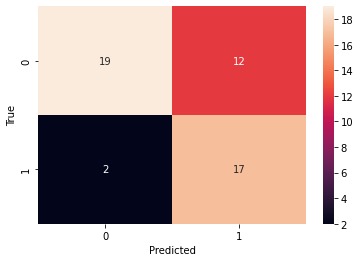

In [ ]:
# Accuracy and classification report
target_names = ['true_y', 'predicted_y']

data = {'true_y': true_y,
       'predicted_y': test_predictions}

df_pred_BERT = pd.DataFrame(data, columns=['true_y','predicted_y'])

confusion_matrix = pd.crosstab(df_pred_BERT['true_y'], df_pred_BERT['predicted_y'], rownames=['True'], colnames=['Predicted'])

sns.heatmap(confusion_matrix, annot=True)
plt.show()

In [ ]:
print('Accuracy of BERT model', accuracy_score(true_y, test_predictions))

Accuracy of BERT model 0.72


In [ ]:
print(classification_report(true_y, test_predictions, target_names=target_names))

              precision    recall  f1-score   support

      true_y       0.90      0.61      0.73        31
 predicted_y       0.59      0.89      0.71        19

    accuracy                           0.72        50
   macro avg       0.75      0.75      0.72        50
weighted avg       0.78      0.72      0.72        50



# Try Logistic regression

In this section I am going to train a Logistic Regression model by using a Pipeline containing the TfidfVectorizer and LogisticRegression. Also, I am going to apply a GridSearchCV to the Pipeline to find the best parameters for the model. This is going to find the optimal parameters, however, it's a bit time consuming.

In [ ]:
# Create a Pipeline with the TfidfVectorizer and LogisticRegression model
LR_pipeline = Pipeline(steps = [('tf', TfidfVectorizer()),
                                ('lgrg', LogisticRegression())]) # initialize TfidfVectorizer and LogisticRegression


# Create Parameter Grid
pgrid_lgrg = {
 'tf__max_features' : [1000, 2000, 3000],
 'tf__ngram_range' : [(1,1),(1,2)],
 'tf__use_idf' : [True, False],
 'lgrg__penalty' : ['l1', 'l2', 'elasticnet', 'none'],
 'lgrg__class_weight' : ['balanced', None]
}

# Apply GridSearch to Pipeline to find the best parameters
gs_lgrg = GridSearchCV(LR_pipeline, pgrid_lgrg, cv=2, n_jobs=-1, verbose=2)

In [ ]:
gs_lgrg.fit(x_train, y_train) # Train LR model

Fitting 2 folds for each of 96 candidates, totalling 192 fits


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
192 fits failed out of a total of 192.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
192 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/pipeline.py", line 390, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/pipeline.py", line 348, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/usr/local/lib/python3.8/dist-packa

ValueError: ignored

In [ ]:
gs_lgrg.best_params_

In [ ]:
print('Score of train set', gs_lgrg.score(x_train, y_train))
print('Score of test set',gs_lgrg.score(x_test, y_test))

In [ ]:
LR_pred = gs_lgrg.predict(x_test) # Predict on validation data

data = {'true_y': y_test,
       'predicted_y': LR_pred}
df_pred = pd.DataFrame(data, columns=['true_y','predicted_y'])
confusion_matrix = pd.crosstab(df_pred['true_y'], df_pred['predicted_y'], rownames=['True'], colnames=['Predicted'])

sns.heatmap(confusion_matrix, annot=True)
plt.show()

In [ ]:
print('Accuracy of LR model', accuracy_score(y_test, LR_pred))

In [ ]:
print(classification_report(y_test, LR_pred, target_names=target_names))

As we can see, we are obtaining a 0.99 acc by just training a Logistic Regression model. Sometimes the simplest solution is the best choice to solve a certain task if it can save us computation time. In any case, the results are very similar.